# Random Forest


# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint

from joblib import dump
from tqdm import tqdm 
from itertools import product

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Loading the dataset

In [2]:
df = pd.read_csv('../dataset/bank-preprocessed.csv')

In [3]:
df['y'].value_counts()

0    38257
1     5037
Name: y, dtype: int64

# Splitting data into training and testing

In [4]:
# Data description oriented to remove the "duration" column to create more realistic models

X = df.drop(["y", "duration"], axis = 1)
y = df["y"]

In [5]:
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED, stratify=y)

# Validating the model

In [6]:
model = RandomForestClassifier(random_state=SEED)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7652
           1       0.61      0.22      0.32      1007

    accuracy                           0.89      8659
   macro avg       0.76      0.60      0.63      8659
weighted avg       0.87      0.89      0.87      8659



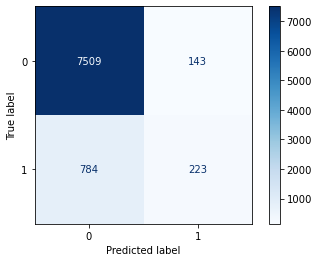

In [8]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')

### Parameters

In [9]:
n_estimators = list(range(10, 400, 20))
criterions = ["gini", "entropy"]
max_features = ["sqrt", "auto", "log2"]

In [10]:
search_space = tuple(product(n_estimators, criterions, max_features))

print("Amount of training sets that will be validate: ", len(search_space))

Amount of training sets that will be validate:  120


Cross validation with k=10.

In [11]:
def search_cross_valid(search_space, X_train, y_train, SEED=42):
    scores_test, scores_valid, params = [], [], []

    for n_est, crt, max_f in tqdm(search_space, desc="Treinamento: "):
        model = RandomForestClassifier(n_estimators=n_est, criterion=crt, max_features=max_f, random_state=SEED)

        cv = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)

        steps = [('model', model)]
        pipeline = Pipeline(steps=steps)

        scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
        
        model.fit(X_train, y_train)
        score_test = precision_score(y_test, model.predict(X_test), average="micro")
        
        print('Mean f1: %.3f' % np.mean(scores))
        print('Accuracy test: %.3f' % score_test)

        parm = dict(n_estimators=n_est, criterion=crt, max_features=max_f)

        print("Parameters: ", parm)
        print("Score of validation: ", np.mean(scores))

        scores_valid.append(np.mean(scores))
        scores_test.append(score_test)
        params.append(parm)

    zipped_results = zip(scores_test, scores_valid, params)
    best_result =  max(zipped_results, key = lambda res: res[1])
    best_score_test, best_score_valid, best_params = best_result

    print('------------------------------')
    print("Best parameters: ", best_params)
    print("Best validation score: ", best_score_valid)
    print("Best validation score: ", best_score_test)
    
    return scores_test, best_score_test, scores_valid, best_score_valid, params, best_params

In [12]:
scores_test, best_score_test, scores_valid, best_score_valid, params, best_params = search_cross_valid(search_space, X_train, y_train)

Treinamento:   1%|          | 1/120 [00:03<06:43,  3.39s/it]

Mean f1: 0.890
Accuracy test: 0.888
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8898222232522095


Treinamento:   2%|▏         | 2/120 [00:05<05:28,  2.78s/it]

Mean f1: 0.890
Accuracy test: 0.888
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8898222232522095


Treinamento:   2%|▎         | 3/120 [00:07<04:12,  2.15s/it]

Mean f1: 0.891
Accuracy test: 0.888
Parameters:  {'n_estimators': 10, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8905730173613635


Treinamento:   3%|▎         | 4/120 [00:08<03:46,  1.95s/it]

Mean f1: 0.890
Accuracy test: 0.890
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.890428675559978


Treinamento:   4%|▍         | 5/120 [00:10<03:30,  1.83s/it]

Mean f1: 0.890
Accuracy test: 0.890
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.890428675559978


Treinamento:   5%|▌         | 6/120 [00:11<03:15,  1.71s/it]

Mean f1: 0.891
Accuracy test: 0.889
Parameters:  {'n_estimators': 10, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8910060010843767


Treinamento:   6%|▌         | 7/120 [00:15<04:22,  2.32s/it]

Mean f1: 0.893
Accuracy test: 0.891
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8928827946239993


Treinamento:   7%|▋         | 8/120 [00:19<05:14,  2.80s/it]

Mean f1: 0.893
Accuracy test: 0.891
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8928827946239993


Treinamento:   8%|▊         | 9/120 [00:22<05:38,  3.05s/it]

Mean f1: 0.894
Accuracy test: 0.890
Parameters:  {'n_estimators': 30, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8936046203381307


Treinamento:   8%|▊         | 10/120 [00:26<06:03,  3.30s/it]

Mean f1: 0.894
Accuracy test: 0.888
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.893806573816639


Treinamento:   9%|▉         | 11/120 [00:30<06:22,  3.51s/it]

Mean f1: 0.894
Accuracy test: 0.888
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.893806573816639


Treinamento:  10%|█         | 12/120 [00:34<06:25,  3.57s/it]

Mean f1: 0.894
Accuracy test: 0.890
Parameters:  {'n_estimators': 30, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8940375707162289


Treinamento:  11%|█         | 13/120 [00:40<07:38,  4.29s/it]

Mean f1: 0.893
Accuracy test: 0.892
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8930848564734818


Treinamento:  12%|█▏        | 14/120 [00:46<08:23,  4.75s/it]

Mean f1: 0.893
Accuracy test: 0.892
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8930848564734818


Treinamento:  12%|█▎        | 15/120 [00:51<08:28,  4.84s/it]

Mean f1: 0.894
Accuracy test: 0.890
Parameters:  {'n_estimators': 50, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8941243091767207


Treinamento:  13%|█▎        | 16/120 [00:57<09:02,  5.22s/it]

Mean f1: 0.894
Accuracy test: 0.891
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8936045453120716


Treinamento:  14%|█▍        | 17/120 [01:03<09:29,  5.53s/it]

Mean f1: 0.894
Accuracy test: 0.891
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8936045453120716


Treinamento:  15%|█▌        | 18/120 [01:09<09:32,  5.61s/it]

Mean f1: 0.894
Accuracy test: 0.890
Parameters:  {'n_estimators': 50, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8944418111223966


Treinamento:  16%|█▌        | 19/120 [01:17<10:38,  6.32s/it]

Mean f1: 0.894
Accuracy test: 0.893
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.894239757609143


Treinamento:  17%|█▋        | 20/120 [01:25<11:12,  6.73s/it]

Mean f1: 0.894
Accuracy test: 0.893
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.894239757609143


Treinamento:  18%|█▊        | 21/120 [01:32<11:28,  6.96s/it]

Mean f1: 0.895
Accuracy test: 0.890
Parameters:  {'n_estimators': 70, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.894759438111504


Treinamento:  18%|█▊        | 22/120 [01:41<12:07,  7.42s/it]

Mean f1: 0.894
Accuracy test: 0.891
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8944417777774814


Treinamento:  19%|█▉        | 23/120 [01:51<13:26,  8.31s/it]

Mean f1: 0.894
Accuracy test: 0.891
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8944417777774814


Treinamento:  20%|██        | 24/120 [02:00<13:52,  8.68s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 70, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8947882814630947


Treinamento:  21%|██        | 25/120 [02:12<15:01,  9.49s/it]

Mean f1: 0.894
Accuracy test: 0.893
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8943841160829862


Treinamento:  22%|██▏       | 26/120 [02:23<15:29,  9.89s/it]

Mean f1: 0.894
Accuracy test: 0.893
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8943841160829862


Treinamento:  22%|██▎       | 27/120 [02:32<15:15,  9.84s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 90, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8952214402469124


Treinamento:  23%|██▎       | 28/120 [02:44<15:56, 10.40s/it]

Mean f1: 0.894
Accuracy test: 0.892
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.894413001115721


Treinamento:  24%|██▍       | 29/120 [02:55<16:10, 10.66s/it]

Mean f1: 0.894
Accuracy test: 0.892
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.894413001115721


Treinamento:  25%|██▌       | 30/120 [03:06<16:02, 10.69s/it]

Mean f1: 0.894
Accuracy test: 0.892
Parameters:  {'n_estimators': 90, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8944129427621194


Treinamento:  26%|██▌       | 31/120 [03:19<16:56, 11.42s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8945861445875535


Treinamento:  27%|██▋       | 32/120 [03:32<17:12, 11.73s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8945861445875535


Treinamento:  28%|██▊       | 33/120 [03:43<16:53, 11.65s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 110, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8952502502535881


Treinamento:  28%|██▊       | 34/120 [03:57<17:40, 12.33s/it]

Mean f1: 0.894
Accuracy test: 0.891
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8944707128275888


Treinamento:  29%|██▉       | 35/120 [04:12<18:22, 12.97s/it]

Mean f1: 0.894
Accuracy test: 0.891
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8944707128275888


Treinamento:  30%|███       | 36/120 [04:24<17:57, 12.83s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 110, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8947017180634071


Treinamento:  31%|███       | 37/120 [04:40<18:50, 13.62s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8945861445875535


Treinamento:  32%|███▏      | 38/120 [04:55<19:17, 14.11s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8945861445875535


Treinamento:  32%|███▎      | 39/120 [05:08<18:52, 13.98s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 130, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8951347684762508


Treinamento:  33%|███▎      | 40/120 [05:25<19:41, 14.77s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8947883314804678


Treinamento:  34%|███▍      | 41/120 [05:41<20:02, 15.22s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8947883314804678


Treinamento:  35%|███▌      | 42/120 [05:57<19:57, 15.35s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 130, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8951925385417201


Treinamento:  36%|███▌      | 43/120 [06:15<20:43, 16.15s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.894586161260011


Treinamento:  37%|███▋      | 44/120 [06:33<21:02, 16.61s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.894586161260011


Treinamento:  38%|███▊      | 45/120 [06:48<20:25, 16.35s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 150, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8951636618452141


Treinamento:  38%|███▊      | 46/120 [07:09<21:38, 17.55s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.89490384660272


Treinamento:  39%|███▉      | 47/120 [07:27<21:38, 17.79s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.89490384660272


Treinamento:  40%|████      | 48/120 [07:44<21:09, 17.63s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 150, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8948461015459369


Treinamento:  41%|████      | 49/120 [08:06<22:25, 18.95s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8947594214390465


Treinamento:  42%|████▏     | 50/120 [08:31<24:04, 20.63s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8947594214390465


Treinamento:  42%|████▎     | 51/120 [08:51<23:25, 20.37s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 170, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8952213652208535


Treinamento:  43%|████▎     | 52/120 [09:16<24:51, 21.93s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8948460515285642


Treinamento:  44%|████▍     | 53/120 [09:42<25:53, 23.19s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8948460515285642


Treinamento:  45%|████▌     | 54/120 [10:04<25:07, 22.83s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 170, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8952214735918276


Treinamento:  46%|████▌     | 55/120 [10:27<24:40, 22.78s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8946150629652033


Treinamento:  47%|████▋     | 56/120 [10:48<23:48, 22.31s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8946150629652033


Treinamento:  48%|████▊     | 57/120 [11:08<22:35, 21.51s/it]

Mean f1: 0.896
Accuracy test: 0.891
Parameters:  {'n_estimators': 190, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8955389338563595


Treinamento:  48%|████▊     | 58/120 [11:33<23:11, 22.44s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8950481884041057


Treinamento:  49%|████▉     | 59/120 [11:56<23:13, 22.84s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8950481884041057


Treinamento:  50%|█████     | 60/120 [12:19<22:43, 22.73s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 190, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8951059834782615


Treinamento:  51%|█████     | 61/120 [12:43<22:46, 23.16s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 210, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8949037965853475


Treinamento:  52%|█████▏    | 62/120 [13:08<22:49, 23.61s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 210, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8949037965853475


Treinamento:  52%|█████▎    | 63/120 [13:29<21:55, 23.07s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 210, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8953079953103711


Treinamento:  53%|█████▎    | 64/120 [13:56<22:31, 24.14s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 210, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8952213985657685


Treinamento:  54%|█████▍    | 65/120 [14:22<22:39, 24.73s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 210, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8952213985657685


Treinamento:  55%|█████▌    | 66/120 [14:46<22:02, 24.49s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 210, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8945862446222987


Treinamento:  56%|█████▌    | 67/120 [15:12<22:03, 24.96s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 230, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8947883314804675


Treinamento:  57%|█████▋    | 68/120 [15:39<22:05, 25.49s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 230, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8947883314804675


Treinamento:  57%|█████▊    | 69/120 [16:03<21:15, 25.00s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 230, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8953079619654559


Treinamento:  58%|█████▊    | 70/120 [16:32<21:46, 26.14s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 230, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8950770734368403


Treinamento:  59%|█████▉    | 71/120 [17:00<21:58, 26.91s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 230, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8950770734368403


Treinamento:  60%|██████    | 72/120 [17:26<21:18, 26.64s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 230, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8950193533887438


Treinamento:  61%|██████    | 73/120 [17:56<21:30, 27.45s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 250, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8945862112773837


Treinamento:  62%|██████▏   | 74/120 [18:26<21:36, 28.18s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 250, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8945862112773837


Treinamento:  62%|██████▎   | 75/120 [18:52<20:41, 27.60s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 250, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8951924885243475


Treinamento:  63%|██████▎   | 76/120 [19:24<21:16, 29.01s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 250, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8951059251246599


Treinamento:  64%|██████▍   | 77/120 [19:56<21:19, 29.76s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 250, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8951059251246599


Treinamento:  65%|██████▌   | 78/120 [20:24<20:38, 29.49s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 250, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8950482134127921


Treinamento:  66%|██████▌   | 79/120 [20:57<20:48, 30.45s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 270, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8947883564891537


Treinamento:  67%|██████▋   | 80/120 [21:30<20:52, 31.31s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 270, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8947883564891537


Treinamento:  68%|██████▊   | 81/120 [22:02<20:25, 31.44s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 270, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8950769650658661


Treinamento:  68%|██████▊   | 82/120 [22:37<20:36, 32.54s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 270, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.895163636836528


Treinamento:  69%|██████▉   | 83/120 [23:11<20:18, 32.93s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 270, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.895163636836528


Treinamento:  70%|███████   | 84/120 [23:42<19:20, 32.24s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 270, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8953947087621767


Treinamento:  71%|███████   | 85/120 [24:16<19:04, 32.69s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 290, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.894990468356009


Treinamento:  72%|███████▏  | 86/120 [24:48<18:31, 32.69s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 290, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.894990468356009


Treinamento:  72%|███████▎  | 87/120 [25:17<17:24, 31.64s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 290, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8950769900745525


Treinamento:  73%|███████▎  | 88/120 [25:53<17:34, 32.95s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 290, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8951925218692626


Treinamento:  74%|███████▍  | 89/120 [26:29<17:22, 33.64s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 290, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8951925218692626


Treinamento:  75%|███████▌  | 90/120 [27:01<16:35, 33.17s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 290, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8951059751420326


Treinamento:  76%|███████▌  | 91/120 [27:36<16:20, 33.81s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 310, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8947594714564191


Treinamento:  77%|███████▋  | 92/120 [28:11<15:55, 34.12s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 310, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8947594714564191


Treinamento:  78%|███████▊  | 93/120 [28:42<14:58, 33.29s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 310, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8952502419173592


Treinamento:  78%|███████▊  | 94/120 [29:20<15:04, 34.79s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 310, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8953080620002012


Treinamento:  79%|███████▉  | 95/120 [29:59<14:58, 35.93s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 310, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8953080620002012


Treinamento:  80%|████████  | 96/120 [30:33<14:08, 35.34s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 310, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8947883314804675


Treinamento:  81%|████████  | 97/120 [31:10<13:43, 35.80s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 330, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.894903813257805


Treinamento:  82%|████████▏ | 98/120 [31:47<13:13, 36.07s/it]

Mean f1: 0.895
Accuracy test: 0.893
Parameters:  {'n_estimators': 330, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.894903813257805


Treinamento:  82%|████████▎ | 99/120 [32:20<12:23, 35.40s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 330, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8951636285002991


Treinamento:  83%|████████▎ | 100/120 [33:01<12:20, 37.01s/it]

Mean f1: 0.896
Accuracy test: 0.892
Parameters:  {'n_estimators': 330, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8956256306357074


Treinamento:  84%|████████▍ | 101/120 [33:42<12:02, 38.02s/it]

Mean f1: 0.896
Accuracy test: 0.892
Parameters:  {'n_estimators': 330, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8956256306357074


Treinamento:  85%|████████▌ | 102/120 [34:18<11:15, 37.53s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 330, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8948172331856599


Treinamento:  86%|████████▌ | 103/120 [34:57<10:46, 38.02s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 350, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8947305947599133


Treinamento:  87%|████████▋ | 104/120 [35:37<10:14, 38.43s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 350, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8947305947599133


Treinamento:  88%|████████▊ | 105/120 [36:12<09:21, 37.44s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 350, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8951636535089854


Treinamento:  88%|████████▊ | 106/120 [36:55<09:08, 39.20s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 350, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8953946920897191


Treinamento:  89%|████████▉ | 107/120 [37:38<08:43, 40.25s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 350, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8953946920897191


Treinamento:  90%|█████████ | 108/120 [38:17<07:58, 39.91s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 350, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8949615666508167


Treinamento:  91%|█████████ | 109/120 [38:58<07:22, 40.27s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 370, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.894615071301432


Treinamento:  92%|█████████▏| 110/120 [39:40<06:47, 40.71s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 370, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.894615071301432


Treinamento:  92%|█████████▎| 111/120 [40:17<05:57, 39.69s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 370, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.8953079953103711


Treinamento:  93%|█████████▎| 112/120 [41:03<05:31, 41.50s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 370, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8951925968953216


Treinamento:  94%|█████████▍| 113/120 [41:48<04:58, 42.60s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 370, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8951925968953216


Treinamento:  95%|█████████▌| 114/120 [42:29<04:12, 42.09s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 370, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8948749699062141


Treinamento:  96%|█████████▌| 115/120 [43:13<03:33, 42.67s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 390, 'criterion': 'gini', 'max_features': 'sqrt'}
Score of validation:  0.8946439813428532


Treinamento:  97%|█████████▋| 116/120 [43:57<02:52, 43.04s/it]

Mean f1: 0.895
Accuracy test: 0.892
Parameters:  {'n_estimators': 390, 'criterion': 'gini', 'max_features': 'auto'}
Score of validation:  0.8946439813428532


Treinamento:  98%|█████████▊| 117/120 [44:36<02:05, 41.98s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 390, 'criterion': 'gini', 'max_features': 'log2'}
Score of validation:  0.89522139022954


Treinamento:  98%|█████████▊| 118/120 [45:25<01:28, 44.02s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 390, 'criterion': 'entropy', 'max_features': 'sqrt'}
Score of validation:  0.8951348518385386


Treinamento:  99%|█████████▉| 119/120 [48:00<01:17, 77.23s/it]

Mean f1: 0.895
Accuracy test: 0.891
Parameters:  {'n_estimators': 390, 'criterion': 'entropy', 'max_features': 'auto'}
Score of validation:  0.8951348518385386


Treinamento: 100%|██████████| 120/120 [48:36<00:00, 24.30s/it]

Mean f1: 0.895
Accuracy test: 0.890
Parameters:  {'n_estimators': 390, 'criterion': 'entropy', 'max_features': 'log2'}
Score of validation:  0.8950770651006117
------------------------------
Best parameters:  {'n_estimators': 330, 'criterion': 'entropy', 'max_features': 'sqrt'}
Best validation score:  0.8956256306357074
Best validation score:  0.8916734033953112


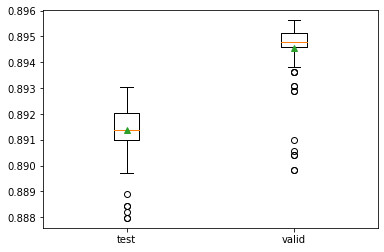

In [13]:
plt.boxplot([scores_test, scores_valid], labels=['test', 'valid'], showmeans=True)
plt.show()

In [14]:
print("Test")
print('Mean: ', np.mean(scores_test), '  ----  Standard deviation: ', np.std(scores_test))
print('-------------------------')
print('Validation')
print('Mean: ', np.mean(scores_valid), '  ----  Standard deviation: ', np.std(scores_valid))

Test
Mean:  0.8913760249451438   ----  Standard deviation:  0.0010079667638178678
-------------------------
Validation
Mean:  0.8945578245427245   ----  Standard deviation:  0.001099249255435669


The mean of the results is 0.89, but in the data this is because the data is unbalanced and for the majority class the model is very correct, but for the minority class it is very wrong.

### Saving models results

In [15]:
results_rf = pd.DataFrame({'model': 'Random Forest', 'parameters': params, 'valid_score': scores_valid})

results_rf

,model,parameters,valid_score
0,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.889822
1,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.889822
2,Random Forest,"{'n_estimators': 10, 'criterion': 'gini', 'max...",0.890573
3,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.890429
4,Random Forest,"{'n_estimators': 10, 'criterion': 'entropy', '...",0.890429
...,...,...,...
115,Random Forest,"{'n_estimators': 390, 'criterion': 'gini', 'ma...",0.894644
116,Random Forest,"{'n_estimators': 390, 'criterion': 'gini', 'ma...",0.895221
117,Random Forest,"{'n_estimators': 390, 'criterion': 'entropy', ...",0.895135
118,Random Forest,"{'n_estimators': 390, 'criterion': 'entropy', ...",0.895135


In [40]:
results_rf_bests = results_rf.sort_values(by=['valid_score'], ascending=False).iloc[:10]

In [41]:
results_rf_bests

,model,parameters,valid_score
99,Random Forest,"{'n_estimators': 330, 'criterion': 'entropy', ...",0.895626
100,Random Forest,"{'n_estimators': 330, 'criterion': 'entropy', ...",0.895626
56,Random Forest,"{'n_estimators': 190, 'criterion': 'gini', 'ma...",0.895539
83,Random Forest,"{'n_estimators': 270, 'criterion': 'entropy', ...",0.895395
106,Random Forest,"{'n_estimators': 350, 'criterion': 'entropy', ...",0.895395
105,Random Forest,"{'n_estimators': 350, 'criterion': 'entropy', ...",0.895395
93,Random Forest,"{'n_estimators': 310, 'criterion': 'entropy', ...",0.895308
94,Random Forest,"{'n_estimators': 310, 'criterion': 'entropy', ...",0.895308
62,Random Forest,"{'n_estimators': 210, 'criterion': 'gini', 'ma...",0.895308
110,Random Forest,"{'n_estimators': 370, 'criterion': 'gini', 'ma...",0.895308


In [42]:
results_rf_bests.to_csv("../models/random_forest_results.csv", index=False)

## Instantiating model with best parameters

The best parameter set was {'n_estimators': 1, 'criterion': 'gini', 'max_features': 'auto'}.

In [18]:
best_params

{'n_estimators': 330, 'criterion': 'entropy', 'max_features': 'sqrt'}

In [19]:
model_best = RandomForestClassifier(**best_params, random_state=SEED)

## Training Model

In [20]:
model_best.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=330, random_state=42)

## Model testing with unbalanced data

In [21]:
print(classification_report(y_test, model_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7652
           1       0.60      0.21      0.31      1007

    accuracy                           0.89      8659
   macro avg       0.75      0.59      0.62      8659
weighted avg       0.87      0.89      0.87      8659



The model's accuracy was 0,89. It is worth mentioning that the database was unbalanced and that the model performance improved after we balanced.

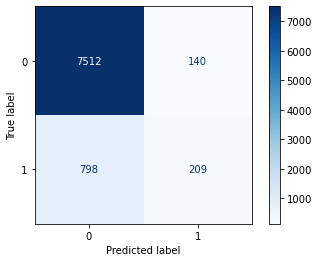

In [22]:
ConfusionMatrixDisplay.from_estimator(model_best, X_test, y_test, cmap='Blues', values_format='d')

In the confusion matrix, we observed that 798 were predictions of class 0, but actually of class 1. While only 209 records were predicted as of class 0 and class 1. This higher number of hits of class 0 is justified by the fact of having more records of that class and the model can learn more about the behavior of the data of that class.

# Balanced Data

## Over Sampling Method

In [23]:
X_train_oversample, y_train_oversample = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)

In [24]:
y_train_oversample.mean()

0.5

In [25]:
model_best_balanced = RandomForestClassifier(**best_params, random_state=SEED)

In [26]:
model_best_balanced.fit(X_train_oversample, y_train_oversample)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=330, random_state=42)

In [27]:
print(classification_report(y_test, model_best_balanced.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      7652
           1       0.52      0.30      0.38      1007

    accuracy                           0.89      8659
   macro avg       0.71      0.63      0.66      8659
weighted avg       0.87      0.89      0.87      8659



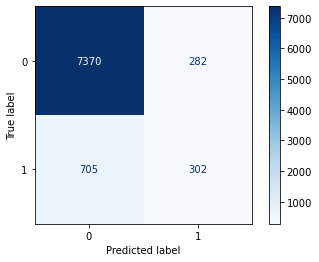

In [28]:
ConfusionMatrixDisplay.from_estimator(model_best_balanced, X_test, y_test, cmap='Blues', values_format='d')

In the confusion matrix, we observed that 705 were predictions of class 0, but actually of class 1. While only 302 records were predicted as of class 0 and class 1.

## Under Sampling Method

In [29]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours 

X_train_upsample, y_train_upsample = RepeatedEditedNearestNeighbours().fit_resample(X_train, y_train)
model_best_balanced = RandomForestClassifier(**best_params, random_state=SEED)
model_best_balanced.fit(X_train_upsample, y_train_upsample)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=330, random_state=42)

In [30]:
print(classification_report(y_test, model_best_balanced.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7652
           1       0.46      0.42      0.44      1007

    accuracy                           0.88      8659
   macro avg       0.69      0.68      0.68      8659
weighted avg       0.87      0.88      0.87      8659



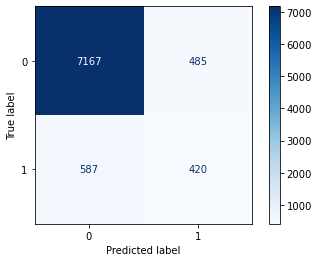

In [31]:
ConfusionMatrixDisplay.from_estimator(model_best_balanced, X_test, y_test, cmap='Blues', values_format='d')

In the confusion matrix, we observed that 587 were predictions of class 0, but actually of class 1. While only 420 records were predicted as of class 0 and class 1.

# Standardization data

## Train and test

In [32]:
scaler = MinMaxScaler()
scaler.fit(X_train_upsample)

X_train_scaled = scaler.transform(X_train_upsample)
X_test_scaled = scaler.transform(X_test)

In [33]:
model_scaled = RandomForestClassifier(**best_params, random_state=SEED)

In [34]:
model_scaled.fit(X_train_scaled, y_train_upsample)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=330, random_state=42)

In [35]:
print(classification_report(y_test, model_scaled.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7652
           1       0.46      0.42      0.44      1007

    accuracy                           0.88      8659
   macro avg       0.69      0.68      0.68      8659
weighted avg       0.87      0.88      0.87      8659



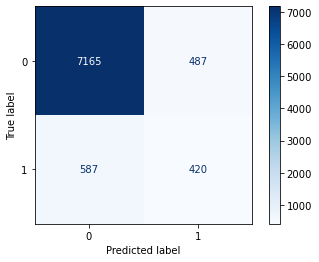

In [36]:
ConfusionMatrixDisplay.from_estimator(model_scaled, X_test_scaled, y_test, cmap='Blues', values_format='d')

The results were not changed using the standardization.

# Feature Importances
Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

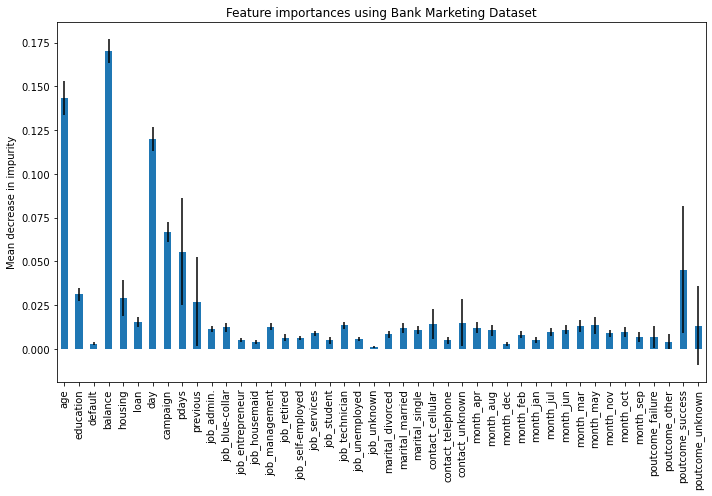

In [37]:
feature_names = list(df.columns)
feature_names.remove('y')
feature_names.remove('duration')

importances = model_best_balanced.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_best_balanced.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Bank Marketing Dataset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The five most important columns for the model are balance, age, day, campaign and pdays, respectively.

# Exporting model

Reference: https://scikit-learn.org/stable/modules/model_persistence.html

In [38]:
dump(model_scaled, '../models/random_forest.joblib') 

['../models/random_forest.joblib']